In [131]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
import warnings
warnings.simplefilter('ignore')
import plotly.express as px
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from tqdm import tqdm

In [73]:
DefectDF = pd.read_excel('Defects_Data.xlsx')

In [74]:
DefectDF.set_index('Defect ID',inplace = True)

In [75]:
DefectDF.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description
Defect ID,,,,,,,,,,,,,,,,
1,ABCD 1231: Status coming on Web UI is different,MarthaN,2020-08-01,ABCD 1231 : Web UI Validation,Closed,3 - Non-Critical,2 - Medium,JonasK,3,2020-08-04,Time is an endless loop. So we need time to fi...,SIT,Technical constraints,SIT1,WEB1,Status shown is declined instead of approved
2,ABCD 1231: Field is missing on Web UI,HannahK,2017-10-12,ABCD 1231 : Web UI Validation,Awaiting Retest,2 - Critical,1 - High,NoahMC,4,2017-10-16,Decision machine is down,PAT,Code,SIT2,WEB2,Field A is missing on Web UI
3,ABCD 1231: Field is added on Web UI,UlrichN,2017-04-19,ABCD 1231 : Web UI Validation,Deferred,1 - Showstopper,1 - High,AdamMC,6,2017-04-25,CB Pull is down,PROD,Data,UAT1,WEB3,Field A is added on UI
4,ABCD 1231: Field value is different on Web UI,AgnesN,2016-11-01,ABCD 1231 : Web UI Validation,Fixed,4 - Live with,3 - Low,HelgeD,13,2016-11-14,MQ is down,UAT,Design,UAT2,WEB4,Field A is showing different value
5,ABCD 1231: Field value is different on Web UI,ClaudiaT,2016-03-07,ABCD 1231 : Web UI Validation,Monitor,2 - Critical,1 - High,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value


In [94]:
DefectDF.isnull().sum()

Defect Summary            0
Detected By               0
Detection Date            0
Subject                   0
Status                    0
Severity                  0
Priority                  0
Assigned to               0
Actual Fix Time           0
Closing Date              0
Dev Comments              0
Detected in Phase         0
Root Cause                0
Detected in Cycle         0
Application under Test    0
Description               0
dtype: int64

# EDA

Text(0.5, 1.0, '.............Top Testers................')

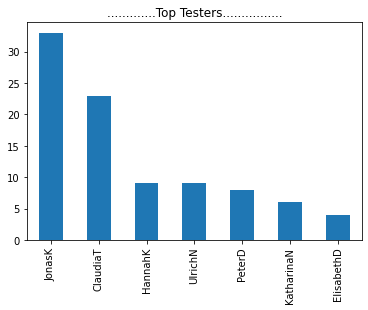

In [95]:
#plt.figure(figsize=(20,10))
DefectDF['Detected By'].value_counts().sort_values(ascending=False).head(7).plot(kind='bar')
plt.title('.............Top Testers................')

Text(0.5, 1.0, '.............Top Developers who get assigned to the defect................')

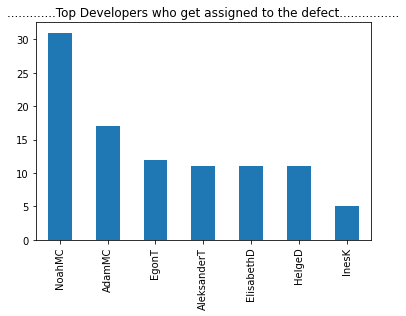

In [96]:
DefectDF['Assigned to'].value_counts().sort_values(ascending=False).head(7).plot(kind='bar')
plt.title('.............Top Developers who get assigned to the defect................')

Text(0.5, 1.0, '.............Applications having defects in PROD................')

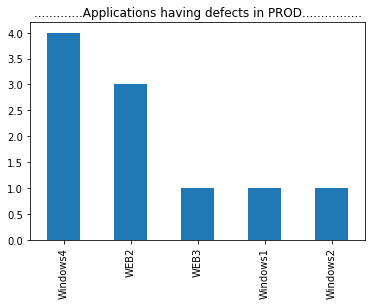

In [97]:
DefectDF[DefectDF['Detected in Phase']=='PROD']['Application under Test'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('.............Applications having defects in PROD................')

In [76]:
DefectDF['year'] = pd.DatetimeIndex(DefectDF["Detection Date"]).year

In [77]:

DefectDF = DefectDF.sort_values(by="Detection Date")
df1 = DefectDF.copy()
df1['count'] = df1.groupby(['Application under Test','year'])['Application under Test'].transform('count')
fig = px.line(df1, x='year', y='count', color='Application under Test',width=700, height=400, title = "Defect Count Application wise")
fig.show()

In [99]:
df2 = df1[df1['Application under Test']=='Windows4']
df2.drop_duplicates(subset='year', keep="first",inplace = True)
fig = go.Figure(data=[go.Bar(x=df2.year, y=df2['count'], text = df2['count'],textposition='auto')])
fig.show()

In [78]:
lemma = WordNetLemmatizer()
stopwords_list = stopwords.words('english')
def cleanText(text):    
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    words = text.split()
    #clean_words = [word for word in words if (word not in stopwords_list ) and len(word) > 2] 
    clean_words = [word for word in words if (word not in stopwords_list )] 
    normalized = [lemma.lemmatize(NewWord) for NewWord in clean_words]
    return " ".join(clean_words)

In [79]:
DefectNew = DefectDF.copy()

In [101]:
df3 = DefectDF[DefectDF['Application under Test']=='Windows4']
df3['Dev Comments'] = df3['Dev Comments'].apply(lambda x: cleanText(x))

(-0.5, 799.5, 499.5, -0.5)

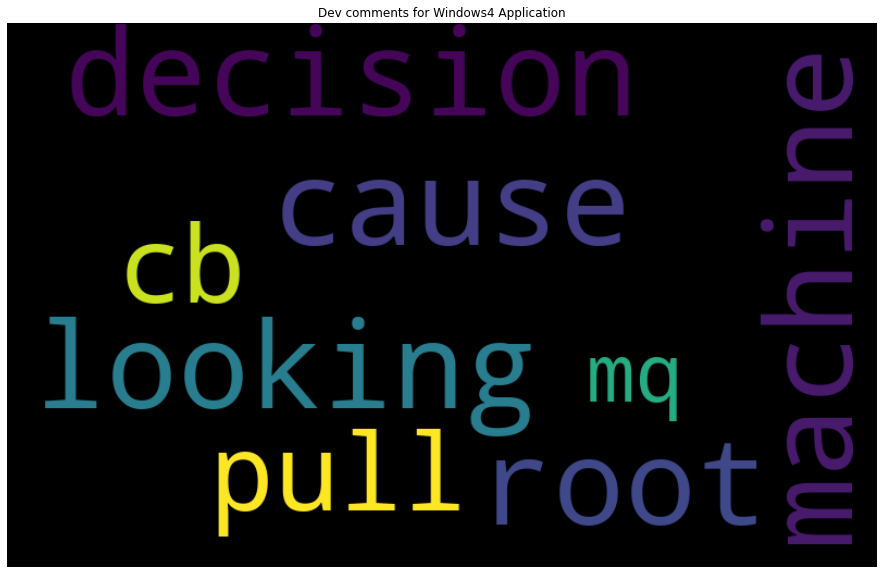

In [102]:
all_words=' '.join(df3['Dev Comments'])

# generate wordcloud object
wordcloud=WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# plot wordcloud
plt.figure(figsize=(20,10))
plt.title('Dev comments for Windows4 Application')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [103]:
df3['Dev Comments']

Defect ID
54                    mq
74    looking root cause
91               cb pull
53    looking root cause
93      decision machine
73    looking root cause
75               cb pull
70      decision machine
90               cb pull
8                cb pull
94      decision machine
72    looking root cause
92    looking root cause
95      decision machine
55                    mq
71      decision machine
Name: Dev Comments, dtype: object

(-0.5, 799.5, 499.5, -0.5)

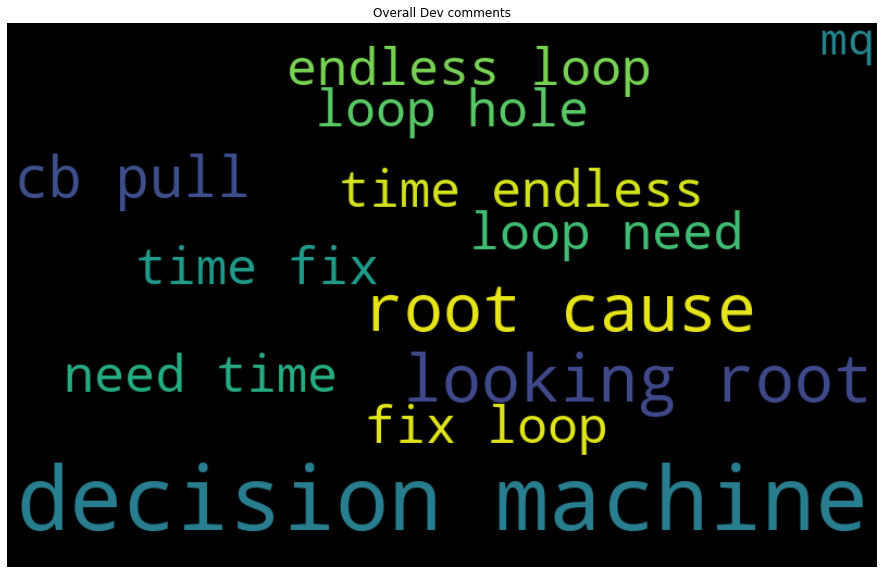

In [104]:
df3 = df1.copy()
df3['Dev Comments'] = df3['Dev Comments'].apply(lambda x: cleanText(x))
all_words=' '.join(df3['Dev Comments'])

# generate wordcloud object
wordcloud=WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# plot wordcloud
plt.figure(figsize=(20,10))
plt.title('Overall Dev comments')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [7]:
print("0.05 quantile :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].quantile(0.05))
print("0.25 quantile :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].quantile(0.25))
print("0.50 quantile :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].quantile(0.50))
print("0.75 quantile :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].quantile(0.75))
print("0.95 quantile :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].quantile(0.95))
print("minimum AFT :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].min())
print("maximum AFT :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].max())
print("mean AFT :-",DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'].mean())

0.05 quantile :- 2.0
0.25 quantile :- 4.0
0.50 quantile :- 7.0
0.75 quantile :- 12.0
0.95 quantile :- 14.699999999999996
minimum AFT :- 1
maximum AFT :- 15
mean AFT :- 8.0


In [8]:
bins=[-1,7.0,12.0,15]
labels=['Low','Medium','High']
DefectDF['AFT Category High']=pd.cut(DefectDF[DefectDF['Priority']=='1 - High']['Actual Fix Time'], bins=bins, labels=labels)

In [9]:
DefectDF.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year,AFT Category High
Defect ID,,,,,,,,,,,,,,,,,,
54,ABCD 2258 : Windows Application is showing low...,JonasK,2016-01-02,ABCD 1147 : Windows PAT Validation,Production,2 - Critical,1 - High,NoahMC,11,2016-01-13,MQ is down,SIT,Code,SIT1,Windows4,The performance of the system is lagging by 30...,2016,Medium
74,ABCD 2258 : Windows Application is showing low...,ClaudiaT,2016-02-05,ABCD 1147 : Windows PAT Validation,New,1 - Showstopper,1 - High,NoahMC,7,2016-02-12,We are looking for the root cause,UAT,Development Documentation,SIT1,Windows4,The performance of the system is lagging by 30...,2016,Low
10,ABCD 5696 : Status coming is different on Wind...,InesK,2016-02-18,ABCD 5696 : Windows UI Validation,Fixed,3 - Non-Critical,2 - Medium,NoahMC,6,2016-02-24,Decision machine is down,SIT,Test case,CR1,WEB3,Status shown is Passed instead of failed,2016,NaN
5,ABCD 1231: Field value is different on Web UI,ClaudiaT,2016-03-07,ABCD 1231 : Web UI Validation,Monitor,2 - Critical,1 - High,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value,2016,Low
14,ABCD 1231: Status coming on Web UI is different,ElisabethD,2016-03-14,ABCD 1231 : Web UI Validation,Closed,2 - Critical,1 - High,NoahMC,5,2016-03-19,Decision machine is down,SPRINT,Development Documentation,CR5,WEB1,Status shown is Passed instead of failed,2016,Low


In [10]:
print("0.05 quantile :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].quantile(0.05))
print("0.25 quantile :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].quantile(0.25))
print("0.50 quantile :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].quantile(0.50))
print("0.75 quantile :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].quantile(0.75))
print("0.95 quantile :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].quantile(0.95))
print("minimum AFT :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].min())
print("maximum AFT :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].max())
print("mean AFT :-",DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'].mean())

0.05 quantile :- 2.1500000000000004
0.25 quantile :- 4.75
0.50 quantile :- 7.0
0.75 quantile :- 10.25
0.95 quantile :- 15.0
minimum AFT :- 2
maximum AFT :- 15
mean AFT :- 7.541666666666667


In [11]:
bins=[-1,7.0,10.25,15]
labels=['Low','Medium','High']
DefectDF['AFT Category']=pd.cut(DefectDF[DefectDF['Priority']=='2 - Medium']['Actual Fix Time'], bins=bins, labels=labels)

In [12]:
DefectDF.tail()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year,AFT Category High,AFT Category
Defect ID,,,,,,,,,,,,,,,,,,,
64,ABCD 2258 : Web Application is showing low per...,KatharinaN,2020-10-18,ABCD 2258 : Web PAT Validation,Fixed,4 - Live with,3 - Low,HelgeD,15,2020-11-02,Decision machine is down,PROD,Design,SIT2,WEB2,The performance of the system is lagging by 30...,2020,NaN,NaN
71,ABCD 5696 : Field value is different on Window...,JonasK,2020-10-30,ABCD 5696 : Windows UI Validation,Closed,2 - Critical,1 - High,NoahMC,15,2020-11-14,Decision machine is down,SIT,Development Documentation,SIT1,Windows4,Field e is showing different value,2020,High,NaN
28,ABCD 2258 : Windows Application is showing low...,JonasK,2020-10-31,ABCD 1147 : Windows PAT Validation,Closed,1 - Showstopper,1 - High,NoahMC,3,2020-11-03,CB Pull is down,UAT,Code,SIT2,WEB1,The performance of the system is lagging by 30...,2020,Low,NaN
45,ABCD 5696 : Field is missing on Windows UI,ClaudiaT,2020-11-17,ABCD 5696 : Windows UI Validation,Fixed,3 - Non-Critical,2 - Medium,AdamMC,15,2020-12-02,Decision machine is down,SIT,Design,SIT2,Windows1,Field f is missing on Windows UI,2020,NaN,High
78,ABCD 1231: Status coming on Web UI is different,KatharinaN,2020-11-23,ABCD 1231 : Web UI Validation,New,4 - Live with,3 - Low,AleksanderT,3,2020-11-26,We are looking for the root cause,SIT,not yet analyzed,Sprint1,Windows1,Status shown is declined instead of approved,2020,NaN,NaN


In [13]:
print("0.05 quantile :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].quantile(0.05))
print("0.25 quantile :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].quantile(0.25))
print("0.50 quantile :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].quantile(0.50))
print("0.75 quantile :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].quantile(0.75))
print("0.95 quantile :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].quantile(0.95))
print("minimum AFT :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].min())
print("maximum AFT :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].max())
print("mean AFT :-",DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'].mean())

0.05 quantile :- 1.0
0.25 quantile :- 4.0
0.50 quantile :- 11.0
0.75 quantile :- 14.0
0.95 quantile :- 15.0
minimum AFT :- 1
maximum AFT :- 15
mean AFT :- 9.206896551724139


In [14]:
bins=[-1,11.0,14.0,15]
labels=['Low','Medium','High']
DefectDF['AFT Category Low']=pd.cut(DefectDF[DefectDF['Priority']=='3 - Low']['Actual Fix Time'], bins=bins, labels=labels)

In [15]:
DefectDF['AFT Category'].fillna(DefectDF['AFT Category Low'], inplace = True)

In [16]:
DefectDF['AFT Category'].fillna(DefectDF['AFT Category High'], inplace = True)

In [17]:
DefectDF.tail()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year,AFT Category High,AFT Category,AFT Category Low
Defect ID,,,,,,,,,,,,,,,,,,,,
64,ABCD 2258 : Web Application is showing low per...,KatharinaN,2020-10-18,ABCD 2258 : Web PAT Validation,Fixed,4 - Live with,3 - Low,HelgeD,15,2020-11-02,Decision machine is down,PROD,Design,SIT2,WEB2,The performance of the system is lagging by 30...,2020,NaN,High,High
71,ABCD 5696 : Field value is different on Window...,JonasK,2020-10-30,ABCD 5696 : Windows UI Validation,Closed,2 - Critical,1 - High,NoahMC,15,2020-11-14,Decision machine is down,SIT,Development Documentation,SIT1,Windows4,Field e is showing different value,2020,High,High,NaN
28,ABCD 2258 : Windows Application is showing low...,JonasK,2020-10-31,ABCD 1147 : Windows PAT Validation,Closed,1 - Showstopper,1 - High,NoahMC,3,2020-11-03,CB Pull is down,UAT,Code,SIT2,WEB1,The performance of the system is lagging by 30...,2020,Low,Low,NaN
45,ABCD 5696 : Field is missing on Windows UI,ClaudiaT,2020-11-17,ABCD 5696 : Windows UI Validation,Fixed,3 - Non-Critical,2 - Medium,AdamMC,15,2020-12-02,Decision machine is down,SIT,Design,SIT2,Windows1,Field f is missing on Windows UI,2020,NaN,High,NaN
78,ABCD 1231: Status coming on Web UI is different,KatharinaN,2020-11-23,ABCD 1231 : Web UI Validation,New,4 - Live with,3 - Low,AleksanderT,3,2020-11-26,We are looking for the root cause,SIT,not yet analyzed,Sprint1,Windows1,Status shown is declined instead of approved,2020,NaN,Low,Low


In [18]:
DefectDF.isnull().sum()

Defect Summary             0
Detected By                0
Detection Date             0
Subject                    0
Status                     0
Severity                   0
Priority                   0
Assigned to                0
Actual Fix Time            0
Closing Date               0
Dev Comments               0
Detected in Phase          0
Root Cause                 0
Detected in Cycle          0
Application under Test     0
Description                0
year                       0
AFT Category High         53
AFT Category               0
AFT Category Low          71
dtype: int64

In [19]:
DefectDF.drop(['AFT Category High','AFT Category Low'],axis = 1, inplace = True)

In [20]:
DefectDF["AFT score"] = DefectDF["AFT Category"].replace({"High": 3, "Medium": 2, "Low": 1})
DefectDF["Priority score"] = DefectDF["Priority"].replace({"1 - High": 3, "2 - Medium": 2, "3 - Low": 1})
DefectDF["Severity score"] = DefectDF["Severity"].replace({"1 - Showstopper": 4,"2 - Critical": 3, "3 - Non-Critical": 2, "4 - Live with": 1})

In [21]:
DefectDF['Total Developer score'] = DefectDF["AFT score"] + DefectDF["Priority score"] + DefectDF["Severity score"]

In [22]:
DefectDF.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year,AFT Category,AFT score,Priority score,Severity score,Total Developer score
Defect ID,,,,,,,,,,,,,,,,,,,,,,
54,ABCD 2258 : Windows Application is showing low...,JonasK,2016-01-02,ABCD 1147 : Windows PAT Validation,Production,2 - Critical,1 - High,NoahMC,11,2016-01-13,MQ is down,SIT,Code,SIT1,Windows4,The performance of the system is lagging by 30...,2016,Medium,2,3,3,8
74,ABCD 2258 : Windows Application is showing low...,ClaudiaT,2016-02-05,ABCD 1147 : Windows PAT Validation,New,1 - Showstopper,1 - High,NoahMC,7,2016-02-12,We are looking for the root cause,UAT,Development Documentation,SIT1,Windows4,The performance of the system is lagging by 30...,2016,Low,1,3,4,8
10,ABCD 5696 : Status coming is different on Wind...,InesK,2016-02-18,ABCD 5696 : Windows UI Validation,Fixed,3 - Non-Critical,2 - Medium,NoahMC,6,2016-02-24,Decision machine is down,SIT,Test case,CR1,WEB3,Status shown is Passed instead of failed,2016,Low,1,2,2,5
5,ABCD 1231: Field value is different on Web UI,ClaudiaT,2016-03-07,ABCD 1231 : Web UI Validation,Monitor,2 - Critical,1 - High,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value,2016,Low,1,3,3,7
14,ABCD 1231: Status coming on Web UI is different,ElisabethD,2016-03-14,ABCD 1231 : Web UI Validation,Closed,2 - Critical,1 - High,NoahMC,5,2016-03-19,Decision machine is down,SPRINT,Development Documentation,CR5,WEB1,Status shown is Passed instead of failed,2016,Low,1,3,3,7


In [23]:
DefectDF['Mean Developer Score'] = DefectDF.groupby(['Assigned to'])['Total Developer score'].transform('mean')

In [24]:
print("0.05 quantile :-",DefectDF['Mean Developer Score'].quantile(0.05))
print("0.25 quantile :-",DefectDF['Mean Developer Score'].quantile(0.25))
print("0.50 quantile :-",DefectDF['Mean Developer Score'].quantile(0.50))
print("0.75 quantile :-",DefectDF['Mean Developer Score'].quantile(0.75))
print("0.95 quantile :-",DefectDF['Mean Developer Score'].quantile(0.95))
print("minimum AvgDev_Score :-",DefectDF['Mean Developer Score'].min())
print("maximum AvgDev_Score :-",DefectDF['Mean Developer Score'].max())
print("mean AvgDev_Score :-",DefectDF['Mean Developer Score'].mean())

0.05 quantile :- 4.818181818181818
0.25 quantile :- 5.363636363636363
0.50 quantile :- 6.083333333333333
0.75 quantile :- 7.225806451612903
0.95 quantile :- 7.225806451612903
minimum AvgDev_Score :- 4.818181818181818
maximum AvgDev_Score :- 9.0
mean AvgDev_Score :- 6.090000000000007


In [25]:
bins=[-1,6.083333333333333,7.225806451612903,9.0]
labels=['Good','Average','Bad']
DefectDF['Developer Category']=pd.cut(DefectDF['Mean Developer Score'], bins=bins, labels=labels)

In [26]:
DefectDF.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year,AFT Category,AFT score,Priority score,Severity score,Total Developer score,Mean Developer Score,Developer Category
Defect ID,,,,,,,,,,,,,,,,,,,,,,,,
54,ABCD 2258 : Windows Application is showing low...,JonasK,2016-01-02,ABCD 1147 : Windows PAT Validation,Production,2 - Critical,1 - High,NoahMC,11,2016-01-13,MQ is down,SIT,Code,SIT1,Windows4,The performance of the system is lagging by 30...,2016,Medium,2,3,3,8,7.225806,Average
74,ABCD 2258 : Windows Application is showing low...,ClaudiaT,2016-02-05,ABCD 1147 : Windows PAT Validation,New,1 - Showstopper,1 - High,NoahMC,7,2016-02-12,We are looking for the root cause,UAT,Development Documentation,SIT1,Windows4,The performance of the system is lagging by 30...,2016,Low,1,3,4,8,7.225806,Average
10,ABCD 5696 : Status coming is different on Wind...,InesK,2016-02-18,ABCD 5696 : Windows UI Validation,Fixed,3 - Non-Critical,2 - Medium,NoahMC,6,2016-02-24,Decision machine is down,SIT,Test case,CR1,WEB3,Status shown is Passed instead of failed,2016,Low,1,2,2,5,7.225806,Average
5,ABCD 1231: Field value is different on Web UI,ClaudiaT,2016-03-07,ABCD 1231 : Web UI Validation,Monitor,2 - Critical,1 - High,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value,2016,Low,1,3,3,7,4.818182,Good
14,ABCD 1231: Status coming on Web UI is different,ElisabethD,2016-03-14,ABCD 1231 : Web UI Validation,Closed,2 - Critical,1 - High,NoahMC,5,2016-03-19,Decision machine is down,SPRINT,Development Documentation,CR5,WEB1,Status shown is Passed instead of failed,2016,Low,1,3,3,7,7.225806,Average


In [27]:
DefectDF[DefectDF['Developer Category']=='Good']['Assigned to'].unique()

array(['AleksanderT', 'InesK', 'AdamMC', 'EgonT', 'HelgeD', 'JonasK'],
      dtype=object)

In [28]:
DefectDF[DefectDF['Developer Category']=='Average']['Assigned to'].unique()

array(['NoahMC', 'ElisabethD'], dtype=object)

In [29]:
DefectDF[DefectDF['Developer Category']=='Bad']['Assigned to'].unique()

array(['MikkelN'], dtype=object)

In [30]:
df3 = DefectDF[['Assigned to','Developer Category']]

In [31]:
df3.drop_duplicates(subset='Assigned to', keep="first")

,Assigned to,Developer Category
Defect ID,,
54,NoahMC,Average
5,AleksanderT,Good
91,ElisabethD,Average
88,InesK,Good
25,AdamMC,Good
21,EgonT,Good
4,HelgeD,Good
6,MikkelN,Bad
1,JonasK,Good


In [80]:
DefectNew["Priority"] = DefectNew["Priority"].replace({"1 - High": 3, "2 - Medium": 2, "3 - Low": 1})
DefectNew["Severity"] = DefectNew["Severity"].replace({"1 - Showstopper": 4,"2 - Critical": 3, "3 - Non-Critical": 2, "4 - Live with": 1})

In [81]:
DefectNew.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year
Defect ID,,,,,,,,,,,,,,,,,
54,ABCD 2258 : Windows Application is showing low...,JonasK,2016-01-02,ABCD 1147 : Windows PAT Validation,Production,3,3,NoahMC,11,2016-01-13,MQ is down,SIT,Code,SIT1,Windows4,The performance of the system is lagging by 30...,2016
74,ABCD 2258 : Windows Application is showing low...,ClaudiaT,2016-02-05,ABCD 1147 : Windows PAT Validation,New,4,3,NoahMC,7,2016-02-12,We are looking for the root cause,UAT,Development Documentation,SIT1,Windows4,The performance of the system is lagging by 30...,2016
10,ABCD 5696 : Status coming is different on Wind...,InesK,2016-02-18,ABCD 5696 : Windows UI Validation,Fixed,2,2,NoahMC,6,2016-02-24,Decision machine is down,SIT,Test case,CR1,WEB3,Status shown is Passed instead of failed,2016
5,ABCD 1231: Field value is different on Web UI,ClaudiaT,2016-03-07,ABCD 1231 : Web UI Validation,Monitor,3,3,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value,2016
14,ABCD 1231: Status coming on Web UI is different,ElisabethD,2016-03-14,ABCD 1231 : Web UI Validation,Closed,3,3,NoahMC,5,2016-03-19,Decision machine is down,SPRINT,Development Documentation,CR5,WEB1,Status shown is Passed instead of failed,2016


In [82]:
DefectNew['Subject'] = DefectNew['Subject'].apply(lambda x: x.split(": ")[1])
DefectNew['Defect Summary'] = DefectNew['Defect Summary'].apply(lambda x: x.split(": ")[1])

In [83]:
DefectNew.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year
Defect ID,,,,,,,,,,,,,,,,,
54,Windows Application is showing low performance...,JonasK,2016-01-02,Windows PAT Validation,Production,3,3,NoahMC,11,2016-01-13,MQ is down,SIT,Code,SIT1,Windows4,The performance of the system is lagging by 30...,2016
74,Windows Application is showing low performance...,ClaudiaT,2016-02-05,Windows PAT Validation,New,4,3,NoahMC,7,2016-02-12,We are looking for the root cause,UAT,Development Documentation,SIT1,Windows4,The performance of the system is lagging by 30...,2016
10,Status coming is different on Windows UI,InesK,2016-02-18,Windows UI Validation,Fixed,2,2,NoahMC,6,2016-02-24,Decision machine is down,SIT,Test case,CR1,WEB3,Status shown is Passed instead of failed,2016
5,Field value is different on Web UI,ClaudiaT,2016-03-07,Web UI Validation,Monitor,3,3,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value,2016
14,Status coming on Web UI is different,ElisabethD,2016-03-14,Web UI Validation,Closed,3,3,NoahMC,5,2016-03-19,Decision machine is down,SPRINT,Development Documentation,CR5,WEB1,Status shown is Passed instead of failed,2016


In [38]:
DefectNew.drop(['Detected By','Detection Date','Assigned to','Closing Date','Application under Test'], axis = 1, inplace= True)

In [84]:
DefectNew.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year
Defect ID,,,,,,,,,,,,,,,,,
54,Windows Application is showing low performance...,JonasK,2016-01-02,Windows PAT Validation,Production,3,3,NoahMC,11,2016-01-13,MQ is down,SIT,Code,SIT1,Windows4,The performance of the system is lagging by 30...,2016
74,Windows Application is showing low performance...,ClaudiaT,2016-02-05,Windows PAT Validation,New,4,3,NoahMC,7,2016-02-12,We are looking for the root cause,UAT,Development Documentation,SIT1,Windows4,The performance of the system is lagging by 30...,2016
10,Status coming is different on Windows UI,InesK,2016-02-18,Windows UI Validation,Fixed,2,2,NoahMC,6,2016-02-24,Decision machine is down,SIT,Test case,CR1,WEB3,Status shown is Passed instead of failed,2016
5,Field value is different on Web UI,ClaudiaT,2016-03-07,Web UI Validation,Monitor,3,3,AleksanderT,7,2016-03-14,We are looking for the root cause,DIT,Development Documentation,Sprint1,Windows1,Field A is showing different value,2016
14,Status coming on Web UI is different,ElisabethD,2016-03-14,Web UI Validation,Closed,3,3,NoahMC,5,2016-03-19,Decision machine is down,SPRINT,Development Documentation,CR5,WEB1,Status shown is Passed instead of failed,2016


In [85]:
le=LabelEncoder()
DefectNew["Status"]=le.fit_transform(DefectNew["Status"])
DefectNew["Detected in Phase"]=le.fit_transform(DefectNew["Detected in Phase"])
DefectNew["Root Cause"]=le.fit_transform(DefectNew["Root Cause"])
DefectNew["Detected in Cycle"]=le.fit_transform(DefectNew["Detected in Cycle"])
DefectNew["Application under Test"]=le.fit_transform(DefectNew["Application under Test"])

In [86]:
DefectNew.head()

,Defect Summary,Detected By,Detection Date,Subject,Status,Severity,Priority,Assigned to,Actual Fix Time,Closing Date,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year
Defect ID,,,,,,,,,,,,,,,,,
54,Windows Application is showing low performance...,JonasK,2016-01-02,Windows PAT Validation,7,3,3,NoahMC,11,2016-01-13,MQ is down,3,1,9,Windows4,The performance of the system is lagging by 30...,2016
74,Windows Application is showing low performance...,ClaudiaT,2016-02-05,Windows PAT Validation,5,4,3,NoahMC,7,2016-02-12,We are looking for the root cause,5,4,9,Windows4,The performance of the system is lagging by 30...,2016
10,Status coming is different on Windows UI,InesK,2016-02-18,Windows UI Validation,3,2,2,NoahMC,6,2016-02-24,Decision machine is down,3,8,1,WEB3,Status shown is Passed instead of failed,2016
5,Field value is different on Web UI,ClaudiaT,2016-03-07,Web UI Validation,4,3,3,AleksanderT,7,2016-03-14,We are looking for the root cause,0,4,11,Windows1,Field A is showing different value,2016
14,Status coming on Web UI is different,ElisabethD,2016-03-14,Web UI Validation,1,3,3,NoahMC,5,2016-03-19,Decision machine is down,4,4,5,WEB1,Status shown is Passed instead of failed,2016


In [87]:
DefectNew['Dev Comments'] = DefectNew['Dev Comments'].apply(lambda x: cleanText(x))
DefectNew['Defect Summary'] = DefectNew['Defect Summary'].apply(lambda x: cleanText(x))
DefectNew['Subject'] = DefectNew['Subject'].apply(lambda x: cleanText(x))
DefectNew['Description'] = DefectNew['Description'].apply(lambda x: cleanText(x))

In [89]:
DefectNew['month'] = pd.DatetimeIndex(DefectNew["Detection Date"]).month

In [134]:
DefectNew.head()

,Defect Summary,Subject,Status,Severity,Priority,Actual Fix Time,Dev Comments,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,Description,year,month,Defect Summary_Vec
Defect ID,,,,,,,,,,,,,,,
54,windows application showing low performance he...,windows pat validation,7,3,3,11,mq,3,1,9,7,performance system lagging seconds heavy load,2016,1,1
74,windows application showing low performance no...,windows pat validation,5,4,3,7,looking root cause,5,4,9,7,performance system lagging seconds normal load,2016,2,1
10,status coming different windows ui,windows ui validation,3,2,2,6,decision machine,3,8,1,2,status shown passed instead failed,2016,2,3
5,field value different web ui,web ui validation,4,3,3,7,looking root cause,0,4,11,4,field showing different value,2016,3,0
14,status coming web ui different,web ui validation,1,3,3,5,decision machine,4,4,5,0,status shown passed instead failed,2016,3,3


In [93]:
DefectNew.drop(['Detected By','Detection Date','Assigned to','Closing Date'], axis = 1, inplace = True)

In [95]:
DefectNew1 = DefectNew.copy()

In [124]:
DefectNew = DefectNew1.copy()

In [129]:
tfidf = TfidfVectorizer()
#vector = tfidf.fit_transform(text)
vector = tfidf.fit_transform(DefectNew['Defect Summary'])

In [130]:
sum_of_sq_dist = {}
for k in tqdm(range(1,15)):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(vector)
    sum_of_sq_dist[k] = km.inertia_
    


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:36<00:00,  2.64s/it]


NameError: name 'sns' is not defined

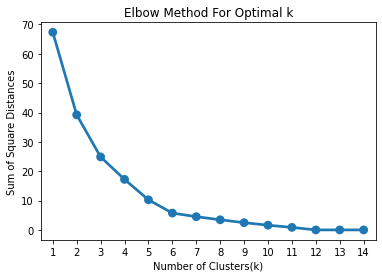

In [132]:
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [133]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(vector)
#DefectNew['Defect Summary_Vec'] = DefectNew['Defect Summary'].apply(lambda x: model.predict(tfidf.transform(x)))
DefectNew['Defect Summary_Vec'] = model.predict(tfidf.transform(DefectNew['Defect Summary']))

In [109]:
# true_k = 4
# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# model.fit(vector)

# print("Top terms per cluster:")
# order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf.get_feature_names()
# for i in range(true_k):
#     print("Cluster %d:" % i),
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind]),
#     print

# print("\n")
# print("Prediction")

# Y = tfidf.transform(["Approved status instead of pending"])
# prediction = model.predict(Y)
# print(prediction)

# Y = tfidf.transform(["System slowness issue"])
# prediction = model.predict(Y)
# print(prediction)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.88it/s]


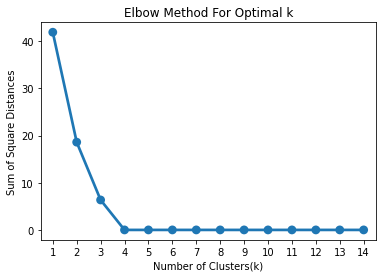

In [135]:
#text = DefectNew['Subject']
tfidf = TfidfVectorizer()
#vector = tfidf.fit_transform(text)
vector = tfidf.fit_transform(DefectNew['Subject'])
#DefectNew['Subject_Vec'] = list(vector.toarray())
sum_of_sq_dist = {}
for k in tqdm(range(1,15)):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(vector)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [136]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(vector)
#DefectNew['Defect Summary_Vec'] = DefectNew['Defect Summary'].apply(lambda x: model.predict(tfidf.transform(x)))
DefectNew['Subject_Vec'] = model.predict(tfidf.transform(DefectNew['Subject']))

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:26<00:00,  1.88s/it]


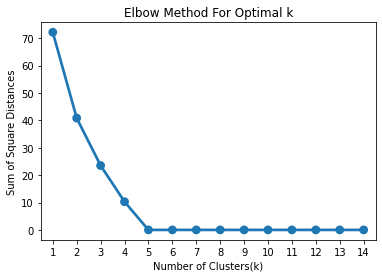

In [137]:
#text = DefectNew['Dev Comments']
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(DefectNew['Dev Comments'])
#DefectNew['Dev Comments_Vec'] = list(vector.toarray())
sum_of_sq_dist = {}
for k in tqdm(range(1,15)):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(vector)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [138]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(vector)
#DefectNew['Defect Summary_Vec'] = DefectNew['Defect Summary'].apply(lambda x: model.predict(tfidf.transform(x)))
DefectNew['Dev Comments_Vec'] = model.predict(tfidf.transform(DefectNew['Dev Comments']))

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [02:32<00:00, 10.92s/it]


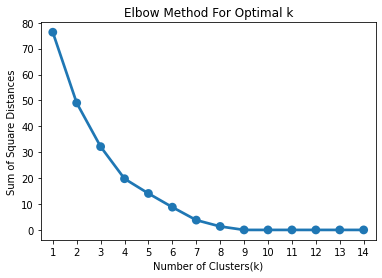

In [139]:
#text = DefectNew['Description']
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(DefectNew['Description'])
#DefectNew['Description_Vec'] = list(vector.toarray())
sum_of_sq_dist = {}
for k in tqdm(range(1,15)):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(vector)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [140]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(vector)
#DefectNew['Defect Summary_Vec'] = DefectNew['Defect Summary'].apply(lambda x: model.predict(tfidf.transform(x)))
DefectNew['Description_Vec'] = model.predict(tfidf.transform(DefectNew['Description']))

In [141]:
DefectNew.drop(['Defect Summary','Subject','Dev Comments','Description'], axis = 1, inplace= True)

In [142]:
DefectNew.head()

,Status,Severity,Priority,Actual Fix Time,Detected in Phase,Root Cause,Detected in Cycle,Application under Test,year,month,Defect Summary_Vec,Subject_Vec,Dev Comments_Vec,Description_Vec
Defect ID,,,,,,,,,,,,,,
54,7,3,3,11,3,1,9,7,2016,1,1,1,4,5
74,5,4,3,7,5,4,9,7,2016,2,1,1,2,1
10,3,2,2,6,3,8,1,2,2016,2,3,3,0,2
5,4,3,3,7,0,4,11,4,2016,3,0,0,2,3
14,1,3,3,5,4,4,5,0,2016,3,3,0,0,2


In [184]:
TrainDf = DefectNew[DefectNew['year']!=2020]

In [185]:
TestDf = DefectNew[DefectNew['year']==2020]

In [186]:
TrainDf.drop('year', axis = 1, inplace= True)
TestDf.drop('year', axis = 1, inplace= True)

In [187]:
x = TrainDf.drop('Detected in Phase', axis = 1)
y = TrainDf['Detected in Phase']

In [188]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [189]:
rf = RandomForestClassifier(random_state=72, max_depth = 25)

In [190]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=72, verbose=0,
                       warm_start=False)

In [191]:
y_pred = rf.predict(X_test)

In [192]:
accuracy_score(y_test,y_pred)

0.4583333333333333

In [193]:
y_pred

array([4, 3, 3, 3, 2, 3, 3, 3, 4, 4, 3, 5, 3, 3, 3, 3, 3, 3, 3, 2, 4, 5,
       3, 3])

In [194]:
x_testdf = TestDf.drop('Detected in Phase', axis = 1)
y_testdf = TestDf['Detected in Phase']

In [195]:
y_pred_test = rf.predict(x_testdf)

In [196]:
accuracy_score(y_testdf,y_pred_test)

0.5454545454545454

<BarContainer object of 12 artists>

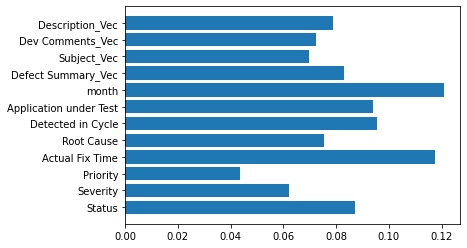

In [197]:
plt.barh(list(x),list(rf.feature_importances_))

In [200]:
!pip install flask